# Sentinel-2 Geomedians on global S2-L2A data

Using element84's Collection 1 data on AWS: https://registry.opendata.aws/sentinel-2-c1-l2a-cogs/

## Import libraries

In [1]:
import os
import xarray as xr
import geopandas as gpd
import dask.distributed
import matplotlib.pyplot as plt
from pystac_client import Client

from odc.geo import BoundingBox
from odc.geo.xr import assign_crs
from odc.io.cgroups import get_cpu_quota
from odc.stac import configure_rio, stac_load
from odc.algo import (
    enum_to_bool,
    geomedian_with_mads,
    erase_bad,
    mask_cleanup,
    keep_good_only
)

## Set up dask

In [2]:
# if dashboard.link set to default value and running behind hub, make dashboard link go via proxy
if dask.config.get("distributed.dashboard.link") == '{scheme}://{host}:{port}/status':
        jup_prefix = os.environ.get('JUPYTERHUB_SERVICE_PREFIX')
        if jup_prefix is not None:
            jup_prefix = jup_prefix.rstrip('/')
            dask.config.set({"distributed.dashboard.link": f"{jup_prefix}/proxy/{{port}}/status"})

#start client
client = dask.distributed.Client(n_workers=1, threads_per_worker=get_cpu_quota())

#make it fast over S3
configure_rio(cloud_defaults=True, aws={"aws_unsigned": True}, client=client)

display(client)

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /user/chad.burton@ga.gov.au/proxy/8787/status,
Dashboard: /user/chad.burton@ga.gov.au/proxy/8787/status,Workers: 1
Total threads: 7.0,Total memory: 62.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:45675,Workers: 1
Dashboard: /user/chad.burton@ga.gov.au/proxy/8787/status,Total threads: 7.0
Started: Just now,Total memory: 62.00 GiB
Comm: tcp://127.0.0.1:40815,Total threads: 7.0
Dashboard: /user/chad.burton@ga.gov.au/proxy/34449/status,Memory: 62.00 GiB
Nanny: tcp://127.0.0.1:42283,


## Analysis Parameters

In [3]:
# Set the central latitude and longitude
central_lat =  -66.281
central_lon =  110.525

# Set the buffer to load around the central coordinates. 
buffer = 0.05

# Compute the bounding box for the study area
latitude = (central_lat - buffer, central_lat + buffer)
longitude = (central_lon - buffer, central_lon + buffer)

# data loading params
crs="EPSG:3031"
start_date = "2024-01-01"
end_date = "2024-12-31"
resolution=20
masking_band = ['scl']
measurements=["red", "green", "blue"]
mask_filters = [("opening", 6), ("dilation", 10)]
# dask_chunks = dict(x=1000, y=1000)

## Set up stac query

In [4]:
bbox = BoundingBox(
    left=central_lon - buffer,
    bottom=central_lat - buffer,
    right=central_lon + buffer,
    top=central_lat + buffer,
    crs=crs
)

catalog = "https://earth-search.aws.element84.com/v1/"

stac_client = Client.open(catalog)

collections_query = ["sentinel-2-c1-l2a"]
date_query = f"{start_date}/{end_date}"
bbox_query = bbox.bbox

items = stac_client.search(
    collections=collections_query,
    datetime=date_query,
    bbox=bbox_query
).item_collection()

print(f"Found {len(items)} items")

Found 46 items


## Display location of data

In [5]:
gdf = gpd.GeoDataFrame.from_features(items, "epsg:4326")
# Compute granule id from components
gdf.explore()

## Load S2 data

In [6]:
ds = stac_load(
    items,
    bands=measurements+masking_band,
    crs=crs,
    chunks={},
    resolution=resolution,
    groupby="solar_day",
    bbox=bbox,
)
ds

<xarray.Dataset> Size: 79MB
Dimensions:      (y: 413, x: 611, time: 45)
Coordinates:
  * y            (y) float64 3kB -9.121e+05 -9.121e+05 ... -9.203e+05 -9.203e+05
  * x            (x) float64 5kB 2.441e+06 2.441e+06 ... 2.453e+06 2.453e+06
    spatial_ref  int32 4B 3031
  * time         (time) datetime64[ns] 360B 2024-01-04T01:56:13.953000 ... 20...
Data variables:
    red          (time, y, x) uint16 23MB dask.array<chunksize=(1, 413, 611), meta=np.ndarray>
    green        (time, y, x) uint16 23MB dask.array<chunksize=(1, 413, 611), meta=np.ndarray>
    blue         (time, y, x) uint16 23MB dask.array<chunksize=(1, 413, 611), meta=np.ndarray>
    scl          (time, y, x) uint8 11MB dask.array<chunksize=(1, 413, 611), meta=np.ndarray>

## Apply Collection 1 offset to reflectance bands

In [7]:
ds[measurements] =  ds[measurements] - 1000

## Create and apply cloud mask

In [8]:
# We need to apply a dictionary as an attribute to this band which stores pixel classifications as integers
ds.scl.attrs = {
    "units": "1",
    "nodata": 0,
    "flags_definition": {
        "qa": {
            "bits": [0, 1, 2, 3, 4, 5, 6, 7],
            "values": {
                "0": "no data",
                "1": "saturated or defective",
                "2": "dark area pixels",
                "3": "cloud shadows",
                "4": "vegetation",
                "5": "bare soils",
                "6": "water",
                "7": "unclassified",
                "8": "cloud medium probability",
                "9": "cloud high probability",
                "10": "thin cirrus",
                "11": "snow or ice",
            },
            "description": "Sen2Cor Scene Classification",
        }
    },
    "crs": crs,
    "grid_mapping": "spatial_ref",
}

#create a binary classification of good/bad data
pq_mask = enum_to_bool(
    mask=ds["scl"],
    categories=(
        "cloud high probability",
        "cloud medium probability",
        "thin cirrus",
        "cloud shadows",
        # "saturated or defective",
    ),
)

# apply morphological filters (might improve cloud mask)
pq_mask = mask_cleanup(pq_mask, mask_filters=mask_filters)

# apply the cloud mask and drop scl layers
ds = erase_bad(ds, where=pq_mask)
ds = ds.drop_vars('scl')

#remove nodata which is == 0
ds = ds.where(ds>0)

# and remove any data that's above 10,000 (very dodgy)
ds = ds.where(ds<=10000)

## RGB plots

/env/lib/python3.10/site-packages/rasterio/warp.py:387: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dest = _reproject(


Text(0.5, 1.0, 'PQ mask')

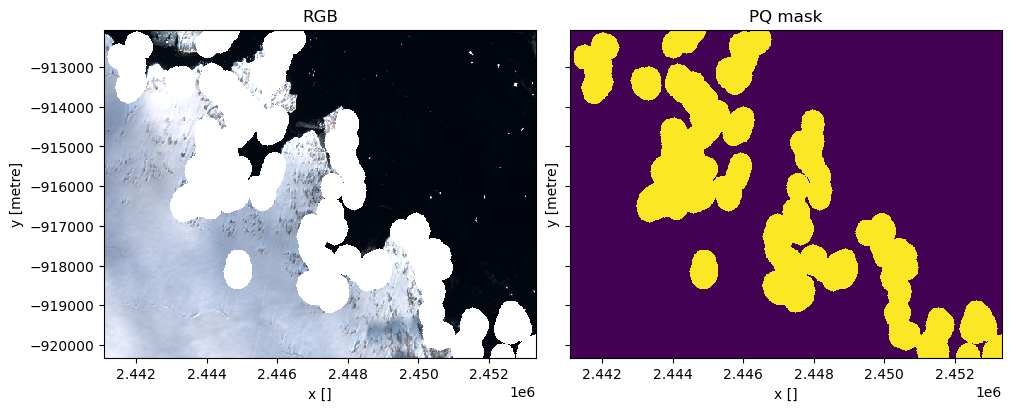

In [9]:
t=15
fig, ax = plt.subplots(1,2, figsize=(10,4), layout='constrained', sharey=True)

ds[['red', 'green', 'blue']].to_array().isel(time=t).plot.imshow(robust=True, ax=ax[0])
pq_mask.isel(time=t).plot(ax=ax[1], add_colorbar=False);
ax[0].set_title(f'RGB')
ax[1].set_title(f'PQ mask')

## Calculate geomedian


In [10]:
s2_gm = geomedian_with_mads(
    ds,
    reshape_strategy='mem', #'yxbt' if data is larger than RAM
    compute_mads=False # True if you want triple MADs
)

# bring into memory
s2_gm = assign_crs(s2_gm.load(), crs=crs)
s2_gm

<xarray.Dataset> Size: 4MB
Dimensions:      (y: 413, x: 611)
Coordinates:
  * y            (y) float64 3kB -9.121e+05 -9.121e+05 ... -9.203e+05 -9.203e+05
  * x            (x) float64 5kB 2.441e+06 2.441e+06 ... 2.453e+06 2.453e+06
    spatial_ref  int32 4B 3031
Data variables:
    red          (y, x) float32 1MB 2.326e+03 2.416e+03 ... 3.276e+03 4.225e+03
    green        (y, x) float32 1MB 2.476e+03 2.544e+03 ... 3.432e+03 4.858e+03
    blue         (y, x) float32 1MB 3.074e+03 3.12e+03 ... 3.872e+03 5.499e+03
    count        (y, x) uint16 505kB 11 11 11 11 11 11 11 11 ... 7 7 7 7 7 7 7 7

## Plot and export images


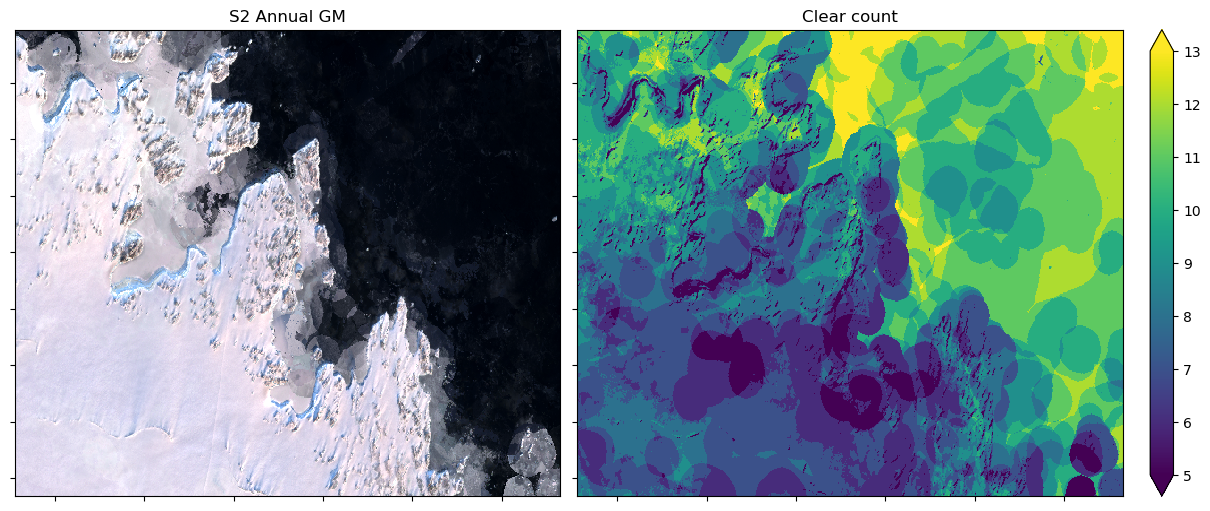

In [11]:
fig, ax = plt.subplots(1,2, figsize=(12,5), layout='constrained')

s2_gm[['red', 'green', 'blue']].to_array().plot.imshow(robust=True, ax=ax[0], add_labels=False)
s2_gm['count'].plot.imshow(robust=True, ax=ax[1], add_labels=False)

ax[0].set_title(f'S2 Annual GM')
ax[1].set_title(f'Clear count')

ax[0].set_yticklabels([])
ax[0].set_xticklabels([])
ax[1].set_yticklabels([])
ax[1].set_xticklabels([]);

# plt.savefig(f'path/to/file/s2_c1_l2a_gm.png', bbox_inches='tight', dpi=300)